# Assignment 04 - Convolutional Neural Networks II (11 Total Points)
<span style='color:red'> Due date: 15.06.2021 23:59</span>

This week's assignment is about Convolutional Neural Networks and Semantic Segmentation. If anything is unclear or if you find errors, feel free to post in the forum set up in Ilias or ask in the WebEx live session, or write an email to one of us.

_You can submit incomplete assignments that don't validate_. If a test cell validates correctly, you will get the points.


---

## Semantic Segmentation (11 Points)
Semantic segmentation has a wide area of applicability, especially in image analysis. It could be used, e.g., for segmenting medical imaging data or CT scans of mechanical specimen of some material, extracting their microstructure. It can also be used to detect structural integrity breaches or segmenting data from array-like sensors.

As an example, we'll use the Pascal Visual Objects Dataset [VOC2012](https://pjreddie.com/projects/pascal-voc-dataset-mirror/)(mirror), which contains images and bitmasks for 20 classes of objects. Here, we'll only use the aeroplanes out of the available sets for demonstration purposes.

Instead of loading the full dataset, we'll also transition to using generators. The `ImageDataGenerator` we got to know in the last assignment and in the lecture today cannot handle tuples of images, so we have to create one generator for the images, and one more for the masks.

First, this cell imports everything we'll need:

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import segmentation_models as sm
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

Segmentation Models: using `tf.keras` framework.


`segmentation_models` is a Python package that automatically builds U-Nets, so we don't have to use the function from the lecture today. It works by loading a `BACKBONE`, that is a CNN pretrained on the *ImageNet* dataset (see transfer learning). This way, good kernel are already available as feature extractors.

Additionally, the input images have to be `preprocessed` for the backbone to work properly (resizing, adjusting the pixel values to $x_{ij} \in [-1,1]$, etc.). The preprocessing function can be loaded easily:

In [2]:
BACKBONE = 'mobilenetv2'
preprocess_input = sm.get_preprocessing(BACKBONE)

Next, we can initialize the generators. The preprocessing function can be provided as an argument. To make sure that both generators create the exact same transformations of both images, we have to initialize the random number generator with the same seed in both cases. The seed is provided to the iterator below.

In the cell below, create *two* `ImageDataGenerator` objects called `image_datagen` and `mask_datagen`. Supply them both with the preprocessing function by providing the argument `preprocessing_function=??`, `width_shift` and `height_shift` of $0.1$, `rotation_range` of $20$, and a `zoom_range` of $0.6$.

In [3]:
### BEGIN SOLUTION
image_datagen = ImageDataGenerator(width_shift_range=0.1,
                                   preprocessing_function=preprocess_input,
                                   height_shift_range=0.1,
                                   rotation_range=20,
                                   zoom_range=0.6)
mask_datagen = ImageDataGenerator(width_shift_range=0.1,
                                  preprocessing_function=preprocess_input,
                                  height_shift_range=0.1,
                                  rotation_range=20,
                                  zoom_range=0.6)
### END SOLUTION


# fixed RNG seed to make sure images and masks are transformed in the same way
seed = 42

# initialize the iterators from the generators above
# they will iterate over all the images in the given directories
# class_mode=None makes sure that no class labels are returned, since 
# the masks are the labels themselves
image_iterator = image_datagen.flow_from_directory("/data/VOC2012/Images", 
                                                   class_mode=None,
                                                   batch_size=8, 
                                                   seed=seed)
mask_iterator   = mask_datagen.flow_from_directory("/data/VOC2012/MasksGray",
                                                   class_mode=None,
                                                   batch_size=8, 
                                                   seed=seed)

train_iterator = zip(image_iterator, mask_iterator)

Found 138 images belonging to 1 classes.
Found 138 images belonging to 1 classes.


In [4]:
for gen in [image_datagen, mask_datagen]:
    assert gen.height_shift_range == 0.1
    assert gen.width_shift_range == 0.1
    assert gen.rotation_range == 20
    assert gen.zoom_range == [0.4, 1.6]


The `train_iterator` zips together both iterators, such that we only need to provide this single object for the training. It will generate both images simultaneously. Let's first check that the transformations make sense:

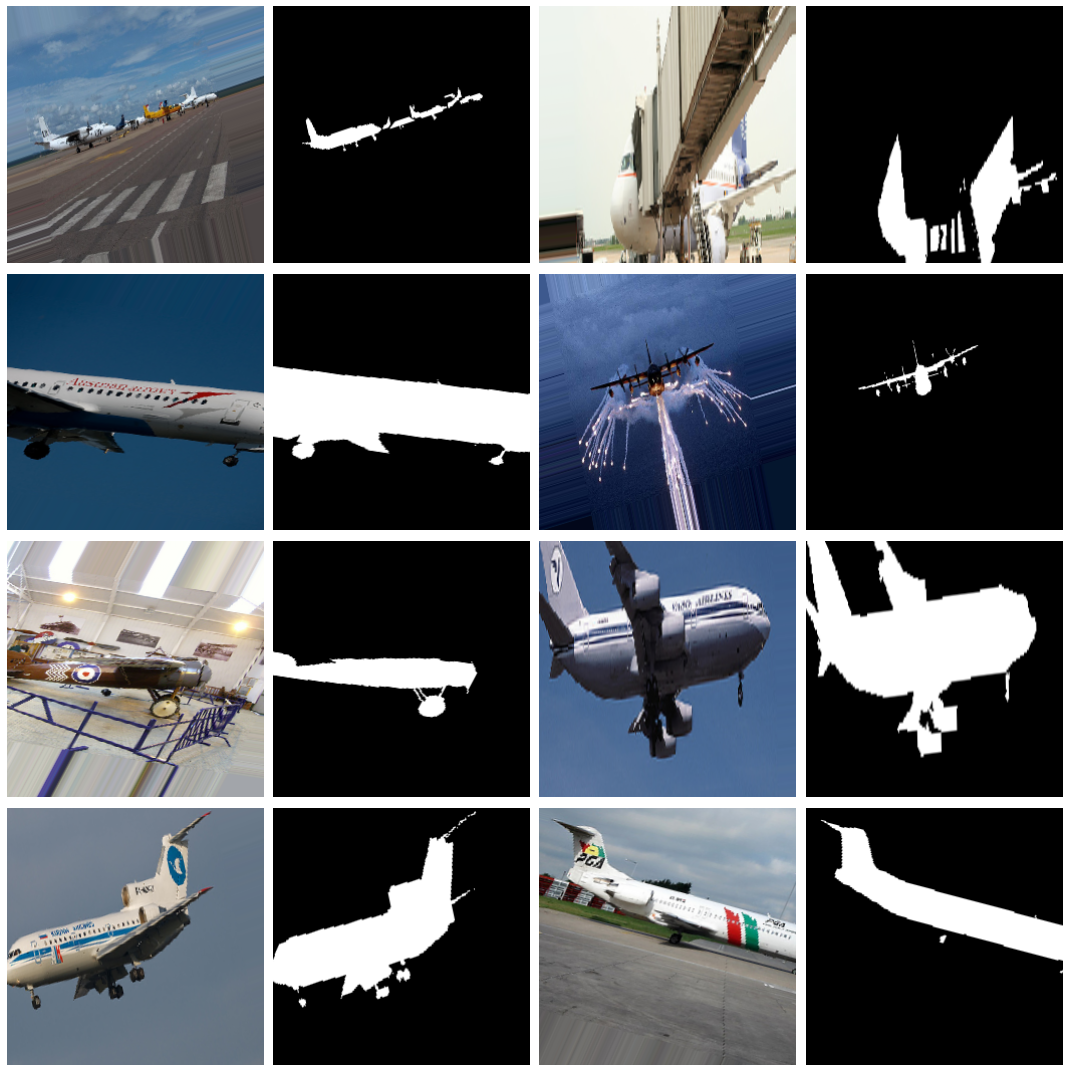

In [5]:
fig,axs = plt.subplots(4,4, figsize=(15,15))
axs = axs.flatten()

img, mask = next(train_iterator)

for i in range(8):
    axs[2*i].imshow((img[i]+1)/2)
    axs[2*i+1].imshow((mask[i]+1)/2)
    
for ax in axs:
    ax.axis("off")

plt.tight_layout()


Some of the images may look too distorted, but all the parameters in the generators are *hyperparameters* that need to be optimized as well. The parameters here are alright for this demonstration, but would require tuning for acceptable results.

Next, we can initialize the model itself. You can check out the `segmentation_models` github page or documentation for help. In the cell below, create a U-Net called `model` that uses the `BACKBONE` from above, `encoder_weights` set to 'imagenet', the number of classes that we'd like to identify here and an appropriate `input_shape`, which has to be a single image's shape (3D, that is). An activation function for the last layer can also be provided. Use `tanh` here.

You can ignore the warning about the input shape (*part of the image will be ignored, since the mobilenetv2 only supports certain image dimensions. Actually, we'd have to rescale the images beforehand, but it's alright for this simple demonstration*).

In [6]:
from tensorflow.keras.backend import clear_session
# define model
clear_session()

### BEGIN SOLUTION
model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=1, input_shape=(256,256,3), activation="tanh")
### END SOLUTION

# and compile it
model.compile('adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])

/usr/local/lib/python3.7/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [7]:


assert len(model.get_config()["layers"]) == 196
assert model.get_config()["layers"][-2]["config"]["filters"] == 1

Training works just like always, but now instead of providing two training sets or two iterators, we only need to provide the `train_iterator` as the first argument. Start the training in the cell below with a `batch_size` of $8$, $8$ `epochs`, and 16 `steps_per_epoch`. Record the training history in a variable called `history` (like before). You can make the progress bar visible with `verbose=1`.

We need the `steps_per_epoch` argument because the generators won't stop generating new input images. This way, the epoch is stopped after 16 batches of 8 images were fed into the network.

Note that the training here will take a long time, around 10 minutes. This becomes much worse if several people perform the training at the same time. 

There is no validation set provided due to performance constraints, but it is very important to include in general.

In [8]:
### BEGIN SOLUTION
history = model.fit(train_iterator, batch_size=8, steps_per_epoch=16, epochs=8, verbose=1)
### END SOLUTION

Epoch 1/8
16/16 [==============================] - 54s 3s/step - loss: 2.5372 - iou_score: 0.5269
Epoch 2/8
16/16 [==============================] - 44s 3s/step - loss: 3.9892 - iou_score: -1.3453
Epoch 3/8
16/16 [==============================] - 42s 3s/step - loss: 2.9293 - iou_score: -1.6022
Epoch 4/8
16/16 [==============================] - 42s 3s/step - loss: 2.5044 - iou_score: -1.6093
Epoch 5/8
16/16 [==============================] - 42s 3s/step - loss: 2.8933 - iou_score: -1.5642
Epoch 6/8
16/16 [==============================] - 43s 3s/step - loss: 2.5282 - iou_score: -1.7572
Epoch 7/8
16/16 [==============================] - 43s 3s/step - loss: 2.2241 - iou_score: -1.8531
Epoch 8/8
16/16 [==============================] - 43s 3s/step - loss: 2.4812 - iou_score: -1.6940


In [14]:
assert history.epoch[-1] == 7
assert history.params["steps"] == 16

We did not provide a validation set due to time constraints, but we can plot the learning curve:

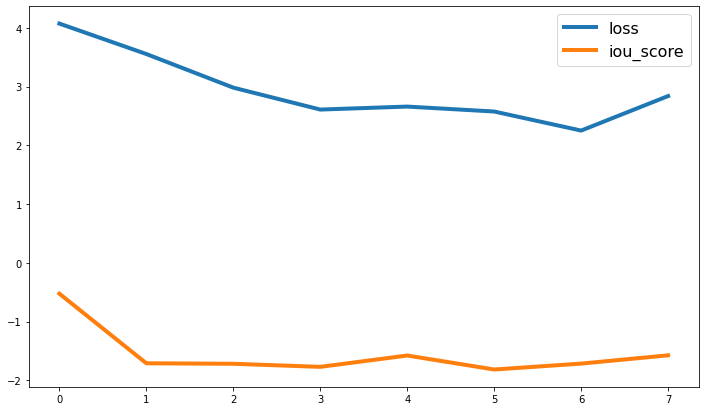

In [10]:
plt.figure(figsize=(12,7))

plt.plot(history.history["loss"], lw=4, label="loss")
plt.plot(history.history["iou_score"], lw=4, label="iou_score")

plt.legend(fontsize=16)

You should see a downwards trend. It would continue with more training. 
In the cell below, `predict` the bitmask for `img`, which is the very first batch of images in the examples plotted in the beginning of this exercise, and save the results in a variable called `y_hat_mask`. To be able to do so, you need to reshape the image array to the shape $(-1,256,256,3)$.

In [15]:
### BEGIN SOLUTION
y_hat_mask = model.predict(img.reshape(-1,256,256,3))
### END SOLUTION

Plotting the predicted bitmask:

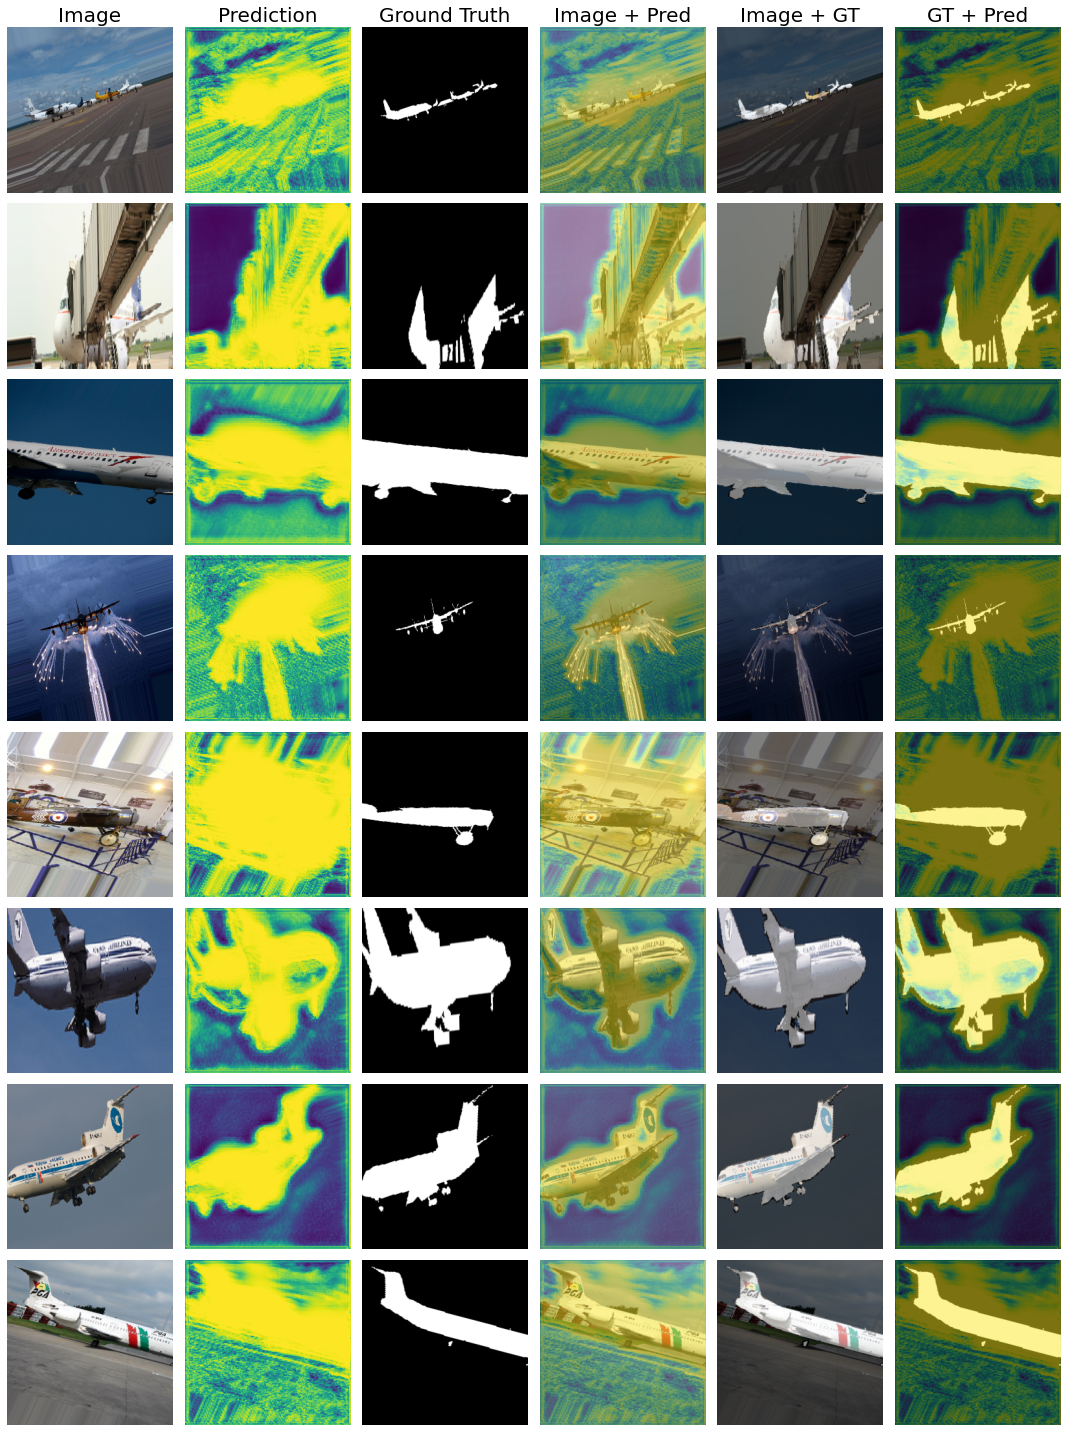

In [23]:
titles = ["Image", "Prediction", "Ground Truth", "Image + Pred", "Image + GT", "GT + Pred"]
samples = 8

fig,axs = plt.subplots(samples,6, figsize=(15,20))

for sample in range(samples):
    axs[sample,0].imshow((img[sample]+1)/2)
    axs[sample,1].imshow(y_hat_mask[sample].reshape(256,256,1))
    axs[sample,2].imshow((mask[sample]+1)/2)
    axs[sample,3].imshow((img[sample]+1)/2)
    axs[sample,3].imshow(y_hat_mask[sample].reshape(256,256,1), alpha=0.5)
    axs[sample,4].imshow((img[sample]+1)/2)
    axs[sample,4].imshow((mask[sample]+1)/2, alpha=0.5)
    axs[sample,5].imshow((mask[sample]+1)/2)
    axs[sample,5].imshow(y_hat_mask[sample].reshape(256,256,1), alpha=0.5)

for i,title in enumerate(titles):
    axs[0,i].set_title(title, fontsize=20)

axs = axs.flatten()

for ax in axs:
    ax.axis("off")

plt.tight_layout()

While this will not be perfect with such a short amount of training, you should at least see the outlines being detected quite okayish (images 5 and 6 usually yield okay results). With more steps per epoch and more epochs in general, this will become much much better. The simple model here has problems especially with occluded aeroplanes. The colors represent *probabilities* and tell you how sure the network is about each prediction pixel.

Note that we did not tell the network which class is which, so the masks above may be reversed.

---

## Loss Functions
Unfortunately, due to time constraints, the discussion of loss functions for image segmentation has to be postponed to next lecture.

---